In [0]:
# 
# This file contains introductory modeling work used for the 
#   2022 Machine Learning Workshop (part of the Software Symposium)!
#   https://FORWARD_SITE/mlworkshop2022 
#      OR https://INFO_SITE/cdo/events/internal-events/4354c5db-3d3d-4481-97c4-8ad8f12686f1
#
# You can (and should) change them for your own experiments, but they are uniquely defined
# here for constants that we will use together.


# Let's Make "NYC Taxi 2025"!
<img src='https://images.pexels.com/photos/5648421/pexels-photo-5648421.jpeg?auto=compress&cs=tinysrgb&w=640&h=427&dpr=2' width='300px' title="no more 'hailing' with preemptive taxis" />

## Background
* In the future, there will be a need to preemptively position resources, like autonomous 
  cars, drones, groceries, etc. Where they may be most needed and right when they're needed
* All of this preemptiveness is accomplished with AI and machine-learned models built with historical data.

This is your chance to build these insights together!! 

### Ground Rules
* In this workshop, we'll start with your CDS data (e.g. taxi rides) and discover ways to augment
  with location, demographic, and other datasets to make better predictions.
* In these notebooks, there will be both a 'beginner' and an 'experienced' set of code that you can 
  execute according to your preference.  
    * The big difference is that the 'beginner' code will mostly load pre-computed data and focus 
      on the illustration of that data instead of the algorithms itself.
* By default, your code will run the _'beginner'_ path.  As a testament to your _'expertness'_ you can 
  edit the configuration file (`utilities/settings.py`) to set this variable.  *(HINT: Look for EXPERIENCED_MODE)*
* [Image source](https://www.pexels.com/photo/unrecognizable-black-man-catching-taxi-on-city-road-5648421/)

### Quick Check: Databricks and Constants
* Databricks (the [cloud-compute platform](https://databricks.com/) you're using now) allows you to write "notebooks" or collections of text and code in "cells" 
* Cells run sequentially and variables / settings persist within a notebook - [check here for a walk through](https://docs.microsoft.com/en-us/azure/databricks/notebooks/notebooks-use)
* Within this workshop, we'll use python and also use several helper scripts that are excuted like this...
```
  %run ../features/location_ops
```
* When exexcuting another notebook with the `%run` command, it's like runnning all of that code in the same notebook.

In [0]:
%run ../features/taxi_dataset

Credentials not detected, creating a new one (name 'CREDENTIALS' is not defined)...
Detected User ID: ez2685

In [0]:
%run ../features/location_ops

Aborting re-definition of credentials...

# Exploring our source data...
* This data comes from a 2009 data dump from [NYC Taxi and Limousine service](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).
* We're loading our data from an ADLS source defined in our settings file, but you can upload your own via the [Blackbird self-service tool](https://blackbird.SERVICE_SITE/).
     * There are even instructions about [loading a CSV sheet](https://data.DOMAIN/resources/knowledge-base/28918666-8b4e-11ec-9463-0f9d673e50a5) (Excel friendly)
     * There are also instructions for a [graphic interface to file uploads](https://data.DOMAIN/resources/knowledge-base/b03da5a8-8e83-11ec-a22b-4d4634dc58c6)
* There are a few types of data columns...
   * *"key"* columns (for both pickup and dropoff times)
     * `pickup_datetime` and `dropoff_datetime` - a timestamp for pickup and dropoff
     * `pickup_longitude` and `pickup_latitude` - location information for a pickup
   * *"data"* columns
     * `passenger_count`, `total_amount` (and others) - that describe the rides themselves
* Finally, note that for speed we're sub-sampling to just 10% of our source data because we're still experimenting.
   * **Tip:** Subsampling can come in very handy to speed up development in the early stages of data exploration.
     
**Extra:** For the experienced users, if you're curious about the spatial encoding we're using, 
it's [Uber's H3 library](https://towardsdatascience.com/uber-h3-for-data-analysis-with-python-1e54acdcc908). 
Check out the settings file in this workshop for a discussion of the h3 resolution we chose.

Date Range: 2009-01-01 00:00:00 - 2019-12-31 00:00:00 (total days 4017)
Total Rides: 1611189506
Avg Fare: 7.928402517225949

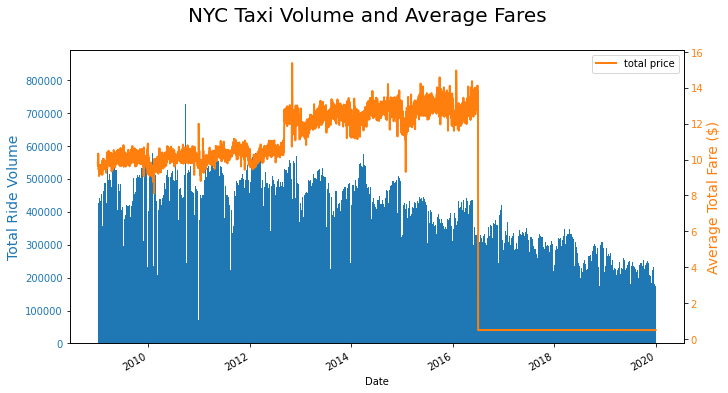

In [0]:
## Just for Visualization ##
# We won't walk through this code, but it gives a peak at how we compute some aggregate
# statistics for the dataset.  We avoid the execution here because it takes several minutes
# for each person to re-run the statistics on this large dataset

# an example of aggregations requried to build a simple time plot
path_read = CREDENTIALS['paths']['nyctaxi_stats']
if CREDENTIALS['constants']['EXPERIENCED_MODE'] and CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:   
    # preprocessing if admin (it's a lot of data)
    path_read_raw = CREDENTIALS['paths']['nyctaxi_raw']
    df_taxi_stats = (
        taxi_filter_raw(spark.read.format('delta').load(path_read_raw))
        .withColumn('date_trunc', F.date_trunc('day', F.col('pickup_datetime')))
        .groupBy('date_trunc').agg(
            F.mean(F.col('fare_amount')).alias('mean_total'),
            F.max(F.col('fare_amount')).alias('max_total'),
            F.min(F.col('fare_amount')).alias('min_total'),
            F.count(F.col('pickup_datetime')).alias('volume'),        
        )
    )
    dbutils.fs.rm(path_read, True)  # destory entirely
    df_taxi_stats.write.format('delta').save(path_read)

# load data, make sure it's sorted by date!
taxi_plot_timeline(spark.read.format('delta').load(path_read))



In [0]:
# load our sampled data (NYC taxi paths)
path_read = CREDENTIALS['paths']['nyctaxi_h3_sampled']

if CREDENTIALS['constants']['EXPERIENCED_MODE']:  # experienced mode shows how the sampling is done
    path_raw = CREDENTIALS['paths']['nyctaxi_raw']
    # don't forget to apply our initial data filter
    df_taxi_raw = dataset_filter_raw(spark.read.format('delta').load(path_raw))
    if not CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:   # subsample if not admin (it's a lot of data)
        df_taxi_raw = df_taxi_raw.sample(CREDENTIALS['constants']['DATA_SUBSAMPLE_RATIO'], seed=42)
    df_taxi_encoded = point_encode_h3(df_taxi_raw, 'dropoff_latitude', 'dropoff_longitude', 
                                      CREDENTIALS['constants']['RESOLUTION_H3'], 'dropoff_h3')
    df_taxi_encoded = point_encode_h3(df_taxi_encoded, 'pickup_latitude', 'pickup_longitude', 
                                      CREDENTIALS['constants']['RESOLUTION_H3'], 'pickup_h3')
    
    if CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:   # if admin, we'll rewrite for the main data copy
        path_full = CREDENTIALS['paths']['nyctaxi_h3']
        path_read = CREDENTIALS['paths']['nyctaxi_h3_sampled']
        dbutils.fs.rm(path_full, True)
        df_taxi_encoded.write.format('delta').save(path_full)
        df_taxi_encoded = spark.read.format('delta').load(path_full)  # this trick clears the execute stack in spark
        df_taxi_encoded = df_taxi_encoded.sample(CREDENTIALS['constants']['DATA_SUBSAMPLE_RATIO'], seed=42)  
        dbutils.fs.rm(path_read, True)
        df_taxi_encoded.write.format('delta').save(path_read)   # this trick clears the execute stack in spark

df_taxi_encoded = spark.read.format('delta').load(path_read)  # read data with geo h3 tag

fn_log(f"Taxi data columns: {df_taxi_encoded.columns}")
display(df_taxi_encoded)

Taxi data columns: ['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code_id', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'dropoff_h3', 'pickup_h3']

vendor_id pickup_datetime dropoff_datetime passenger_count trip_distance pickup_longitude pickup_latitude rate_code_id store_and_fwd_flag dropoff_longitude dropoff_latitude payment_type fare_amount extra mta_tax tip_amount tolls_amount total_amount dropoff_h3 pickup_h3 VTS 2009-11-19T01:13:00.000+0000 2009-11-19T01:19:00.000+0000 1 1.49 -73.9881 40.732112 null null -74.001628 40.717122 Credit 6.1 0.5 0.5 1.2 0.0 8.3 8b2a1072c38efff 8b2a100d22d4fff CMT 2009-11-20T20:58:53.000+0000 2009-11-20T21:00:39.000+0000 1 0.4 -73.98691 40.729714 null 0 -73.988385 40.724075 Credit 3.3 0.5 0.5 1.07 0.0 5.37 8b2a1072cb22fff 8b2a100d22cbfff CMT 2009-11-21T08:40:12.000+0000 2009-11-21T08:49:39.000+0000 1 2.1 -73.988289 40.718726 null 0 -74.003567 40.738872 Cash 8.1 0.0 0.5 0.0 0.0 8.6 8b2a10721b51fff 8b2a1072ca62fff CMT 2009-11-23T00:05:39.000+0000 2009-11-23T00:11:19.000+0000 1 1.1 -73.983685 40.72597 null 0 -74.000913 40.724634 Cash 5.7 0.5 0.5 0.0 0.0 6.7 8b2a1072c119fff 8b2a100d341cfff CMT 2009-11-13T20:09:29.000+0000 2009-11-13T20:19:22.000+0000 1 1.7 -73.977836 40.680318 null 0 -74.000605 40.681405 Credit 7.7 0.5 0.5 1.74 0.0 10.44 8b2a107293b3fff 8b2a100da60dfff CMT 2009-11-21T05:11:04.000+0000 2009-11-21T05:23:51.000+0000 1 5.3 -73.987386 40.733027 null 0 -73.963652 40.795467 Cash 13.7 0.5 0.5 0.0 0.0 14.7 8b2a10088a00fff 8b2a100d22f4fff CMT 2009-11-10T05:32:28.000+0000 2009-11-10T05:34:25.000+0000 1 1.0 -73.987157 40.733402 null 0 -73.977754 40.746333 Cash 4.5 0.5 0.5 0.0 0.0 5.5 8b2a100d2876fff 8b2a100d221afff CMT 2009-11-28T22:23:27.000+0000 2009-11-28T22:34:57.000+0000 1 1.6 -73.983609 40.730126 null 0 -73.99707 40.721256 Cash 7.7 0.5 0.5 0.0 0.0 8.7 8b2a1072ca96fff 8b2a100d35a4fff CMT 2009-11-08T00:05:08.000+0000 2009-11-08T00:13:30.000+0000 2 1.0 -73.980509 40.7219 null 0 -73.994458 40.719675 Credit 6.5 0.5 0.5 1.0 0.0 8.5 8b2a1072ca8cfff 8b2a100d37a5fff CMT 2009-11-29T00:53:54.000+0000 2009-11-29T00:58:20.000+0000 1 1.5 -73.979008 40.666004 null 0 -73.970858 40.681492 Credit 5.7 0.5 0.5 1.0 0.0 7.7 8b2a100da382fff 8b2a10774a95fff CMT 2009-11-30T14:09:18.000+0000 2009-11-30T14:21:26.000+0000 1 3.4 -73.983482 40.731684 null 0 -73.949834 40.773734 Cash 10.5 0.0 0.5 0.0 0.0 11.0 8b2a10089ac8fff 8b2a100d2242fff CMT 2009-11-08T04:50:09.000+0000 2009-11-08T05:00:31.000+0000 1 2.9 -73.986101 40.722345 null 0 -73.991249 40.7501 Cash 9.7 0.5 0.5 0.0 0.0 10.7 8b2a100d2c10fff 8b2a100d34dbfff CMT 2009-11-21T22:19:19.000+0000 2009-11-21T22:25:38.000+0000 2 2.1 -73.984945 40.72777 null 1 -73.968745 40.754144 Cash 7.3 0.5 0.5 0.0 0.0 8.3 8b2a100d630bfff 8b2a100d358afff CMT 2009-11-14T00:05:27.000+0000 2009-11-14T00:11:55.000+0000 1 2.9 -73.982911 40.721109 null 0 -74.012597 40.701633 Cash 8.5 0.5 0.5 0.0 0.0 9.5 8b2a1072806efff 8b2a100d3786fff CMT 2009-11-07T23:13:47.000+0000 2009-11-07T23:30:02.000+0000 1 4.1 -73.987333 40.7186 null 0 -73.961784 40.767795 Cash 12.5 0.5 0.5 0.0 0.0 13.5 8b2a100d690dfff 8b2a1072ca61fff CMT 2009-11-11T00:15:24.000+0000 2009-11-11T00:34:01.000+0000 1 6.0 -73.986774 40.733088 null 0 -73.924422 40.774029 Cash 16.5 0.5 0.5 0.0 0.0 17.5 8b2a100f230bfff 8b2a100d221afff CMT 2009-11-15T01:57:40.000+0000 2009-11-15T02:02:36.000+0000 1 0.8 -73.979577 40.682401 null 0 -73.990944 40.688491 Cash 4.9 0.5 0.5 0.0 0.0 5.9 8b2a1072985cfff 8b2a100da632fff CMT 2009-11-16T12:28:22.000+0000 2009-11-16T12:42:47.000+0000 1 3.7 -73.986432 40.730306 null 0 -74.007949 40.705142 Credit 12.1 0.0 0.5 3.0 0.0 15.6 8b2a10728bb3fff 8b2a100d22cdfff CMT 2009-11-03T13:46:17.000+0000 2009-11-03T13:53:08.000+0000 1 1.6 -73.983958 40.729547 null 0 -73.971493 40.749712 Cash 6.5 0.0 0.5 0.0 0.0 7.0 8b2a100d62ebfff 8b2a100d35a0fff CMT 2009-11-04T15:47:03.000+0000 2009-11-04T15:51:21.000+0000 1 0.7 -73.987957 40.733684 null 0 -73.986423 40.726544 Cash 4.5 0.0 0.5 0.0 0.0 5.0 8b2a100d3484fff 8b2a100d22a8fff CMT 2009-11-25T10:55:08.000+0000 2009-11-25T10:58:57.000+0000 1 0.7 -73.980806 40.721808 null 0 -73.991012 40.728006 Credit 4.5 0.0 0.5 1.25 0.0 6.25 

**Interactive Note**

... and hop back to the slides "CDS Basics – Visualizing your Data" to follow along.

## Let's map to a region for ML/AI Enrichment!
* Okay, now that we have our samples and some undertanding of where they happened, let's map
  them to regions that make sense.
* What location or geographies spring to mind....?
  * Zip codes - **Pro:** mailing zip codes are used all over, **Con:** may be too large of an area?
  * buildings - **Pro:** specific points of interest in a location, **Con:** May not be enough of them
  * citys and states - **Con:** not small enough for our modeling 
* ZIP codes are pretty good, right? Let's start there!
* [Image source](https://www.pexels.com/photo/smartphone-car-technology-phone-33488/)

<img src='https://images.pexels.com/photos/33488/navigation-car-drive-road.jpg?auto=compress&cs=tinysrgb&w=640&h=427&dpr=2' width='300px' title="predicting impacted locations" />

In [0]:
# load geometry for zip codes and filter for NEW YORK state; 
df_shape_zip = (spark.read.format('delta').load(CREDENTIALS['paths']['geometry_zip'])
    .filter(F.col('state')==F.lit('NY'))
)
df_zip_cells = shape_encode_h3cells(df_shape_zip, ['zip'], CREDENTIALS['constants']['RESOLUTION_H3'], 'geometry')

# load geometry for NEW YORK state; convert to geometry presentation format
pdf_shape_states = (spark.read.format('delta').load(CREDENTIALS['paths']['geometry_state'])
    .filter(F.col('stusps')==F.lit('NY'))
    .toPandas()
)
pdf_shape_states['geometry'] = pdf_shape_states['geometry'].apply(lambda x: wkt.loads(x))

# join for both the pick-up and drop off
df_taxi_indexed = (
    point_intersect_h3cells(df_taxi_encoded.withColumnRenamed('pickup_h3', 'h3'),   # temp rename
                            'pickup_latitude', 'pickup_longitude', 
                            CREDENTIALS['constants']['RESOLUTION_H3'], df_zip_cells, col_h3='h3')
    .withColumnRenamed('zip', 'pickup_zip')   # rename merged zip
    .withColumnRenamed('h3', 'pickup_h3').drop('geoid')   # fix rename and drop extra
)
df_taxi_indexed = (
    point_intersect_h3cells(df_taxi_indexed.withColumnRenamed('dropoff_h3', 'h3'),   # temp rename
                            'dropoff_latitude', 'dropoff_longitude', 
                            CREDENTIALS['constants']['RESOLUTION_H3'], df_zip_cells, col_h3='h3')
    .withColumnRenamed('zip', 'dropoff_zip')   # rename merged zip
    .withColumnRenamed('h3', 'dropoff_h3').drop('geoid')   # fix rename and drop extra
)


## n1.e3 Flex your CDS muscle!
Remember, to be a CDS, one doesn't need to know how to program or train ML models to be a **CDS**!  Let's drive that point home.
* What we have so far is a set of data (our taxi records) that we've joined to zip codes.
* So we've enhanced our initial dataset with a spatial record, which is part of our "NYC Taxi 2025" goal.
* One easy thing to do is look at the stats to see if there are any homeruns for zip codes that should be prioritized.
  * To get there, we'll do two things: group by zip code and count those hits
  * Visualize our results to make sure it looks reasonable (there's helper code for that)

Grouping into a plottable dataframe...
Out[36]:

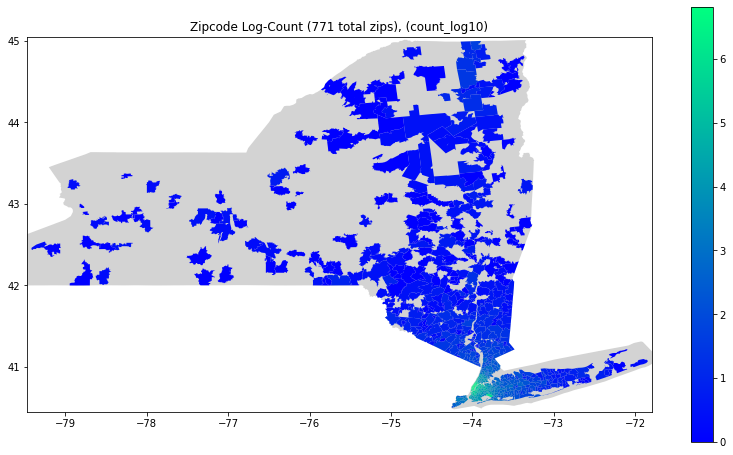

(<Figure size 1008x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Zipcode Log-Count (771 total zips), (count_log10)'}>)

In [0]:
path_read = CREDENTIALS['paths']['nyctaxi_h3_zips']

# only admins write this one (it takes almost 10m to aggregate)
if CREDENTIALS['constants']['EXPERIENCED_MODE'] and CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:  
    # now filter to relevant zips (those found in our taxi data)
    df_zips = (df_taxi_indexed
        .select(F.col('pickup_zip').alias('zip'))   # first sum by pickup
        .groupBy('zip').agg(F.count('zip').alias('count'))
        .union(df_taxi_indexed.select(F.col('dropoff_zip').alias('zip'))   # and then by dropoff
            .groupBy('zip').agg(F.count('zip').alias('count'))
        )
        .groupBy('zip').agg(F.sum('count').alias('count'))  # sum them all together
        .withColumnRenamed('zip', '_zip_join')
    )
    df_zips = (df_zips
        .join(df_shape_zip, df_zips['_zip_join']==df_shape_zip['zip'], 'inner')
        .drop('_zip_join')
        .withColumn('count_log10', F.log(10.0, F.col('count')))
    )
    dbutils.fs.rm(path_read, True)
    df_zips.write.format('delta').save(path_read)

    
fn_log("Grouping into a plottable dataframe...")
df_zips = spark.read.format('delta').load(path_read)
pdf_sub = df_zips.toPandas().sort_values(by='count', ascending=False)
pdf_sub['geometry'] = pdf_sub['geometry'].apply(lambda x: wkt.loads(x))
num_total = len(pdf_sub['count'])
shape_plot_map(pdf_sub, col_viz='count_log10', txt_title=f"Zipcode Log-Count ({num_total} total zips)", 
               gdf_background=pdf_shape_states)


**Interactive Note**

... and hop back to the slides "Live Quiz" to follow along.

### Quiz Time!
Okay, what do you as CDSs think that we can do to improve this data?

1. Filter by costs
2. Filter by zip code
3. Filter by distance
4. Just start over!

In [0]:
# some initial rules to filter zip codes by location
pdf_sub_part = pdf_sub[(pdf_sub['intptlon'] > -74.5) & (pdf_sub['intptlon'] < -73.5) & (pdf_sub['intptlat'] < 41.1)]
num_total = len(pdf_sub_part['count'])
list_cities = pdf_sub_part['city'].unique()
fn_log(f"Cities ({len(list_cities)} unique): {list_cities} ")
shape_plot_map(pdf_sub_part, col_viz='count_log10', txt_title=f"Zipcode Log-Count ({num_total} total zips, {len(list_cities)} total cities)", 
               gdf_background=pdf_shape_states)


Cities (133 unique): ['New York' 'Flushing' 'Jamaica' 'Brooklyn' 'Long Island City' 'Astoria'
 'Woodside' 'Sunnyside' 'Jackson Heights' 'Forest Hills' 'Elmhurst'
 'East Elmhurst' 'Corona' 'Bronx' 'Rego Park' 'Ridgewood' 'Maspeth'
 'South Ozone Park' 'Middle Village' 'Kew Gardens' 'Richmond Hill'
 'South Richmond Hill' 'Fresh Meadows' 'Woodhaven' 'Whitestone'
 'Ozone Park' 'Springfield Gardens' 'Bayside' 'Howard Beach'
 'College Point' 'Hollis' 'Oakland Gardens' 'Queens Village' 'Rosedale'
 'Staten Island' 'Saint Albans' 'Cambria Heights' 'Bellerose' 'Yonkers'
 'Little Neck' 'Far Rockaway' 'Floral Park' 'Glen Oaks' 'New Hyde Park'
 'Elmont' 'Great Neck' 'Rockaway Park' 'Valley Stream' 'Garden City'
 'Lawrence' 'Bronxville' 'Manhasset' 'Pelham' 'New Rochelle' 'Woodmere'
 'Hicksville' 'Scarsdale' 'Cedarhurst' 'Port Washington' 'White Plains'
 'Larchmont' 'Uniondale' 'Arverne' 'Long Beach' 'Rockville Centre'
 'Westbury' 'West Hempstead' 'Mount Vernon' 'Lynbrook' 'Inwood' 'Hewlett'
 'Roslyn' 'Breezy Point' 'Tarrytown' 'Port Chester' 'Levittown'
 'Franklin Square' 'Hempstead' 'Rye' 'West Harrison' 'Roslyn Heights'
 'Mineola' 'Oceanside' 'Baldwin' 'Mamaroneck' 'East Meadow' 'Tuckahoe'
 'Jericho' 'Glen Head' 'Syosset' 'Merrick' 'Malverne' 'Old Westbury'
 'Bellmore' 'Wantagh' 'Hastings On Hudson' 'Atlantic Beach' 'Glen Cove'
 'Freeport' 'Hartsdale' 'Carle Place' 'Purchase' 'Harrison'
 'East Rockaway' 'Albertson' 'Eastchester' 'Elmsford' 'Williston Park'
 'Dobbs Ferry' 'Irvington' 'Sparkill' 'Orangeburg' 'Nanuet'
 'Locust Valley' 'Oyster Bay' 'Nyack' 'Roosevelt' 'Valhalla' 'West Nyack'
 'Island Park' 'Pearl River' 'Ardsley' 'Greenvale' 'Palisades' 'Sea Cliff'
 'Blauvelt' 'East Norwich' 'Mill Neck' 'Tappan' 'Glenwood Landing'
 'Bayville' 'Piermont' 'Point Lookout'] 
Out[37]:

(<Figure size 1008x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Zipcode Log-Count (319 total zips, 133 total cities), (count_log10)'}>)

**Interactive Note**

... and hop back to the slides "Live Quiz! Data Slicing" to follow along

### Know when to fold 'em
Zip code isolation and geospatial filtering wasn't quite enough.
1. Locations go far beyond Manhattan
2. Low-frequency areas (log view from above) like NY state, parts of Long Island and Staten Island still appear

So it's time to look around at what other 
data may be available.  Luckily, NYC's data transparency pays off again and it looks like we have 
records of the NYC T&LC (Taxi & Limousine Commission) zones.

<img src='https://data.cityofnewyork.us/api/assets/3FF54443-CD9C-4E56-8A20-8D2BD245BD1A?nyclogo300.png' width='300px' title="predicting impacted locations" />

Let's grab the shape definitions from this site and try geo identificaiton one more time.

* [Image source](https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc)

In [0]:
# load geometry for zip codes and filter for NEW YORK state; 
df_shape_tlc = spark.read.format('delta').load(CREDENTIALS['paths']['geometry_nyctaxi'])
display(df_shape_tlc)

df_tlc_cells = shape_encode_h3cells(df_shape_tlc, ['zone'], CREDENTIALS['constants']['RESOLUTION_H3'], 'the_geom')

# join for both the pick-up and drop off
df_taxi_indexed = (
    point_intersect_h3cells(df_taxi_encoded.withColumnRenamed('pickup_h3', 'h3'),   # temp rename
                            'pickup_latitude', 'pickup_longitude', 
                            CREDENTIALS['constants']['RESOLUTION_H3'], df_tlc_cells, col_h3='h3')
    .withColumnRenamed('zone', 'pickup_zone')   # rename merged zip
    .withColumnRenamed('h3', 'pickup_h3')   # fix rename and drop extra
)
df_taxi_indexed = (
    point_intersect_h3cells(df_taxi_indexed.withColumnRenamed('dropoff_h3', 'h3'),   # temp rename
                            'dropoff_latitude', 'dropoff_longitude', 
                            CREDENTIALS['constants']['RESOLUTION_H3'], df_tlc_cells, col_h3='h3')
    .withColumnRenamed('zone', 'dropoff_zone')   # rename merged zip
    .withColumnRenamed('h3', 'dropoff_h3')    # fix rename and drop extra
)


objectid shape_leng the_geom shape_area zone locationid borough geometry 1 0.116357453189 MULTIPOLYGON (((-74.18445299999996 40.694995999999904, -74.18448899999999 40.69509499999987, -74.18449799999996 40.69518499999987, -74.18438099999997 40.69587799999989, -74.18428199999994 40.6962109999999, -74.18402099999997 40.697074999999884, -74.18391299999996 40.69750699999986, -74.18375099999997 40.69779499999988, -74.18363399999998 40.6983259999999, -74.18356199999994 40.698451999999875, -74.18354399999998 40.69855999999988, -74.18350799999996 40.69870399999992, -74.18327399999998 40.70008999999988, -74.18315699999994 40.701214999999884, -74.18316599999997 40.702384999999886, -74.18313899999998 40.7026279999999, -74.18309399999998 40.7028529999999, -74.18299499999995 40.70315899999985, -74.18284199999994 40.70346499999989, -74.18264399999998 40.70373499999988, -74.18242799999996 40.70395099999992, -74.18220299999996 40.704139999999896, -74.18203199999994 40.70425699999987, -74.18180699999994 40.7043919999999, -74.18157299999996 40.70449999999988, -74.18132099999997 40.70460799999991, -74.18080799999996 40.7047879999999, -74.179467 40.70534599999992, -74.17887299999995 40.70554399999987, -74.17831499999994 40.70572399999987, -74.17776599999996 40.70589499999988, -74.17709099999996 40.706092999999896, -74.17699199999998 40.70613799999988, -74.17689299999995 40.70619199999988, -74.17664999999994 40.70641699999988, -74.17642499999994 40.706695999999916, -74.17628999999994 40.70689399999988, -74.17608299999995 40.70710999999989, -74.17599299999995 40.70719099999991, -74.17589399999997 40.707262999999905, -74.17565999999994 40.70737999999988, -74.17538099999996 40.707469999999915, -74.17515599999996 40.707514999999894, -74.17475999999994 40.707595999999924, -74.17417499999993 40.70766799999991, -74.17388699999998 40.70773099999992, -74.17347299999994 40.707748999999865, -74.17275299999994 40.707802999999906, -74.17188899999996 40.707910999999854, -74.17163699999998 40.70795599999986, -74.17133999999999 40.707964999999895, -74.17120499999999 40.70795599999986, -74.16994499999998 40.707973999999886, -74.16888299999994 40.7079379999999, -74.16681299999993 40.70785699999989, -74.16442799999999 40.70779399999987, -74.16401399999995 40.70777599999992, -74.16233999999997 40.707721999999876, -74.16081899999995 40.70764099999991, -74.16057599999993 40.70760499999988, -74.16033299999998 40.70756899999987, -74.160063 40.7074879999999, -74.15938799999998 40.707262999999905, -74.15904599999999 40.707145999999916, -74.15891999999997 40.70710999999989, -74.15827199999995 40.70687599999993, -74.15459099999998 40.705651999999894, -74.15409599999998 40.70544499999989, -74.15401499999997 40.70538199999988, -74.15387999999996 40.705327999999895, -74.15376299999997 40.705408999999875, -74.15323199999995 40.70524699999987, -74.15317799999997 40.70531899999989, -74.15306999999996 40.7052829999999, -74.15359199999995 40.70437399999987, -74.15386199999995 40.7038429999999, -74.15513999999996 40.70155699999987, -74.15544599999998 40.70108899999988, -74.15575199999995 40.7006659999999, -74.15600399999994 40.70026099999991, -74.15635499999996 40.69975699999986, -74.15745299999998 40.69809199999988, -74.15754299999998 40.6979389999999, -74.15758799999998 40.69781299999988, -74.15762399999994 40.69767799999991, -74.15829899999994 40.696705999999885, -74.15951399999994 40.69488799999988, -74.15958599999993 40.69476199999984, -74.16014399999995 40.69410499999988, -74.16057599999993 40.693222999999875, -74.16262799999998 40.69028899999989, -74.16279899999995 40.69002799999989, -74.16290699999996 40.68987499999987, -74.16292499999997 40.689874999999866, -74.16295199999996 40.689874999999866, -74.16306899999995 40.68989299999988, -74.16309599999994 40.689928999999886, -74.16322199999996 40.68998299999989, -74.16331199999996 40.68999199999993, -74.16341099999994 40.69000099999988, -74.16352799999999 40.69000999999986, -74.16380699999996 40.69004599999989, -74.16410399999995

In [0]:
path_read = CREDENTIALS['paths']['nyctaxi_h3_zones']

# only admins write this one (it takes almost 10m to aggregate)
if CREDENTIALS['constants']['EXPERIENCED_MODE'] and CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:  
    # now filter to relevant zips (those found in our taxi data)
    df_zones = (df_taxi_indexed
        .select(F.col('pickup_zone').alias('zone'))   # first sum by pickup
        .groupBy('zone').agg(F.count('zone').alias('count'))
        .union(df_taxi_indexed.select(F.col('dropoff_zone').alias('zone'))   # and then by dropoff
            .groupBy('zone').agg(F.count('zone').alias('count'))
        )
        .groupBy('zone').agg(F.sum('count').alias('count'))  # sum them all together
        .withColumnRenamed('zone', '_zone_join')
    )
    df_zones = (df_zones
        .join(df_shape_tlc, df_zones['_zone_join']==df_shape_tlc['zone'], 'inner')
        .drop('_zone_join')
        .withColumn('count_log10', F.log(10.0, F.col('count')))
    )
    dbutils.fs.rm(path_read, True)
    df_zones.write.format('delta').save(path_read)

fn_log("Grouping into a plottable dataframe...")
df_zones = spark.read.format('delta').load(path_read)
pdf_sub = df_zones.toPandas().sort_values(by='count', ascending=False)
pdf_sub['geometry'] = pdf_sub['geometry'].apply(lambda x: wkt.loads(x))
num_total = len(pdf_sub['count'])
shape_plot_map(pdf_sub, col_viz='count_log10', txt_title=f"Zone Log-Count ({num_total} total zones)", 
               gdf_background=pdf_shape_states)


Grouping into a plottable dataframe...
Out[39]:

(<Figure size 1008x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Zone Log-Count (263 total zones), (count_log10)'}>)

## n1.e4 Data Exploration Conclusions
Not too bad, right?  We've come to a few decisions about how to represent our data....

* Group into zones as defined by the NYC T&LC by location
* Incorporating external data can add some SME (subject matter expert) spice to our modeling

We know about ride volume, but let's dig into knowing about our customers as well.

**Interactive Note**

... and hop back to the slides "CDS discussion – Sourcing enrichment data" to follow along.

# n1.e5 - Exploring Customer Data Joins

Now that we have awareness of how to group our data, let's link it to customers.
* Within the company, there are lots of extra data that can add insights to these explorations.
  * Account information - tenure, pricing models, active lines and data
  * Demographics - age, household income, ethnic makeup
  * Behavioral data - phone calls, browser visits, etc.
  
It's important to identify the right way to expand your data.  Which do you think would be most helpful?
  * Account
  * Demographics
  * Behavioral
  * something else?

In [0]:
%run ../features/featurestore_ops

Aborting re-definition of credentials...

In [0]:
path_read = CREDENTIALS['paths']['demographics_raw']
# load geometry for zip codes and filter for NEW YORK state; 
df_shape_tlc = spark.read.format('delta').load(CREDENTIALS['paths']['geometry_nyctaxi'])

# feel free to try this at home, but you DO have to set up some other secrets / codes to use the feature store...
#    see - https://data.DOMAIN/products-and-services/self-service/Atlantis-Feature-Store
if CREDENTIALS['constants']['EXPERIENCED_MODE'] and CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:
    # load raw features from the feature store (this is an *advanced* topic that we'll review in hour 3!)
    df_demos_raw = demographic_load_fs()

    # load geometry for zip codes and filter for NEW YORK state; 
    df_tlc_cells = shape_encode_h3cells(df_shape_tlc, ['zone'], CREDENTIALS['constants']['RESOLUTION_H3'], 'the_geom')

    # join for both the pick-up and drop off
    df_demos_indexed = (
        point_intersect_h3cells(df_demos_raw, 'latitude_cif', 'longitude_cif', 
                                CREDENTIALS['constants']['RESOLUTION_H3'], df_tlc_cells, col_h3='h3')
        .dropna(subset=['zone'])    # drop those that are null (that means they're not in our study area)
        .drop('latitude_cif', 'longitude_cif')    # drop the raw lat/long to avoid SPI/PII danger
        .withColumnRenamed('zone', '_zone_match')   # rename for next matching below
    )
    df_demos_indexed = (df_demos_indexed   # also going to add borough name!
        .join(df_shape_tlc.select('zone', 'borough'),
              df_shape_tlc['zone']==df_demos_indexed['_zone_match'], 'left')
        .drop('_zone_match')
    )
    dbutils.fs.rm(path_read, True)
    df_demos_indexed.write.format('delta').save(path_read)  # save new demographics subset

fn_log("Sneak peak at demographics...")
df_demos_indexed = spark.read.format('delta').load(path_read)
display(df_demos_indexed.limit(10))


Sneak peak at demographics...

zipcd age hshld_income_cd hshld_incme_grp est_curr_home_value exact_age gnrt lang ethnc_grp ethnic_sub_grp gndr marital_status_cif building_area_1_cif lot_size_square_feet_cif market_value_land_cif market_value_improvement_cif number_of_children_in_living_unit_cif number_of_units_cif number_of_bedrooms_cif year_built_cif tax_amount_cif head_of_household_cif length_of_residence_cif edctn state_cif city_cif h3 zone borough 7751 78 167 $150K-$249K null 78 Seniors English General Market Western European F 5M 0 4000 224000 414000 null 2 0 1930 585976 Y null Some College - Likely NY STATEN ISLAND 8b2a10625472fff West Brighton Staten Island 10310 78 167 $150K-$249K null 78 Seniors English General Market Western European F 5M 0 4000 224000 414000 null 2 0 1930 585976 Y null Some College - Likely NY STATEN ISLAND 8b2a10625472fff West Brighton Staten Island 11222 34 25 <$50K 0 34 Millennials Spanish Hispanic Hispanic F 5S null null null null null null null null null Y 3 Less than HS Diploma - Likely NY BROOKLYN 8b2a100d131afff East Williamsburg Brooklyn 11203 75 50 $50K-$99K 792201 75 Boomers English African American African American F 5S 692 1783 266000 429000 null 2 0 1940 1122624 null 29 Less than HS Diploma - Likely NY BROOKLYN 8b2a10766259fff East Flatbush/Farragut Brooklyn 11211 52 1 <$50K 0 52 GenX Unknown Hispanic Hispanic M 5S null null null null null null null null null Y 23 Less than HS Diploma - Likely NY BROOKLYN 8b2a100de562fff Williamsburg (South Side) Brooklyn 11234 38 120 $100K-$149K null 38 Millennials English Asian South Asian F 5M 896 1892 148000 328000 null 2 0 1945 1202093 Y null Bach Degree - Likely NY BROOKLYN 8b2a10760473fff Flatlands Brooklyn 11236 38 120 $100K-$149K null 38 Millennials English Asian South Asian F 5M 896 1892 148000 328000 null 2 0 1945 1202093 Y null Bach Degree - Likely NY BROOKLYN 8b2a10760473fff Flatlands Brooklyn 11238 27 70 $50K-$99K null 27 Millennials English Hispanic Hispanic null 5S null null null null null null null null null Y null Less than HS Diploma - Likely NY BROOKLYN 8b2a100da869fff Bedford Brooklyn 11368 51 30 <$50K 1142808 51 GenX Unknown Asian East Asian M 5S 946 2500 193000 780000 null 2 0 1950 318728 null 0 Less than HS Diploma - Likely NY CORONA 8b2a100c43a8fff Corona Queens 11368 51 30 <$50K 1142808 51 GenX Unknown Asian East Asian M 5S 946 2500 193000 780000 null 2 0 1950 318728 null 0 Less than HS Diploma - Likely NY CORONA 8b2a100c43a8fff Corona Queens

## Demographic Exploration
Demographics are senstive, but in aggregate, they give a peek at the population that you're serving in an area.
From the table above, we have subset of columns (personal addresses and names have been removed) that describe 
several characterstics of the inhabitant. 

*NOTE: These demographics are sourced from an outside vendor so it's outside 
the scope of this workshop to focus on collection or class namings.*

In this notebook, we refer to these as 'demographic factors' and will experiment with joining various factors to
our source data.
* `gnrt` - the "generation" (by age) of the individual (e.g. "Millenials", "GenX", etc.)
* `ethnc_grp` - the ethnic group of the individual (e.g. "Asian", "Hispanic", etc.)
* `gndr` - the gender of the individual (e.g. "F", or "M")
* `edctn` - the education level of the individual (e.g. "Bach Degree - Likely", "Some College - Likely", etc.)
* `marital_status_cif` - marital status (e.g. "5M" or "5S")
* `hshld_incme_grp` - the group household income (e.g. "$150K-$249K", "<$50K", etc.)

For those techncially saavy individuals, we are **not** aggregating by a single household and are instead getting
numbers for everyone that lives in an area.  Numerically that means households that have multiple individuals 
get more weight, but this may only matter if comparing factors like *household income* (`hshld_incme_grp`).

In [0]:
path_read = CREDENTIALS['paths']['demographics_factors']

if CREDENTIALS['constants']['EXPERIENCED_MODE'] and CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:
    df_demos_pivot = demographic_factors_count(df_demos_indexed, list_factors=['zone'])
    winFactor = Window.partitionBy('zone', 'factor')
    df_demos_pivot = (df_demos_pivot    # add z-score to the demographics factors
        .withColumn("cnt_mean", F.mean(F.col('count')).over(winFactor))
        .withColumn("cnt_std", F.stddev(F.col('count')).over(winFactor))
        .withColumn("cnt_zscore", (F.col('count') - F.col('cnt_mean'))/F.col('cnt_std'))
        .drop('cnt_mean', 'cnt_std')
    )
    dbutils.fs.rm(path_read, True)
    df_demos_pivot.write.format('delta').save(path_read)  # save new demographics factorized version

fn_log("Factorized demographics by zone...")
df_demos_pivot = spark.read.format('delta').load(path_read)
list_factors = df_demos_pivot.select('factor').distinct().collect()
fn_log(f"These factors are available: {list_factors}")
display(df_demos_pivot)

# now we'll join
pdf_demos_pivot_shape = (df_demos_pivot
    .join(spark.read.format('delta').load(CREDENTIALS['paths']['geometry_nyctaxi'])
          .select('zone', 'the_geom'), ['zone'])
    .withColumn('count_log10', F.log(10.0, F.col('count')))
    .withColumnRenamed('the_geom', 'geometry')
    .toPandas()
)
pdf_demos_pivot_shape['geometry'] = pdf_demos_pivot_shape['geometry'].apply(lambda x: wkt.loads(x))


Factorized demographics by zone...
These factors are available: [Row(factor='ethnc_grp'), Row(factor='gndr'), Row(factor='edctn'), Row(factor='marital_status_cif'), Row(factor='ethnic_sub_grp'), Row(factor='gnrt'), Row(factor='hshld_incme_grp')]

zone value count factor cnt_zscore Allerton/Pelham Gardens Some College -Extremely Likely 1149 edctn -0.5855973805664109 Allerton/Pelham Gardens Some College - Likely 13975 edctn 2.243259430862496 Allerton/Pelham Gardens Bach Degree - Likely 4188 edctn 0.08467361974018878 Allerton/Pelham Gardens Grad Degree - Extremely Likely 778 edctn -0.6674238172606354 Allerton/Pelham Gardens Less than HS Diploma - Ex Like 14 edctn -0.8359289321781221 Allerton/Pelham Gardens Grad Degree - Likely 2771 edctn -0.2278548460164587 Allerton/Pelham Gardens HS Diploma - Likely 10212 edctn 1.413305572963932 Allerton/Pelham Gardens HS Diploma - Extremely Likely 991 edctn -0.6204452970022262 Allerton/Pelham Gardens Unknown 32 edctn -0.8319589163816368 Allerton/Pelham Gardens Less than HS Diploma - Likely 5755 edctn 0.430285550467547 Allerton/Pelham Gardens Bach Degree - Extremely Likely 1980 edctn -0.4023149846286733 Allerton/Pelham Gardens Asian 3199 ethnc_grp -1.4283974369842927 Allerton/Pelham Gardens African American 13031 ethnc_grp 0.5054389911790955 Allerton/Pelham Gardens Hispanic 14704 ethnc_grp 0.8344980172488013 Allerton/Pelham Gardens General Market 10911 ethnc_grp 0.08846042855639584 Allerton/Pelham Gardens Scandinavian 145 ethnic_sub_grp -0.5378175770011139 Allerton/Pelham Gardens Western European 4275 ethnic_sub_grp 0.3616530890977853 Allerton/Pelham Gardens Eastern European 1577 ethnic_sub_grp -0.22594300221815417 Allerton/Pelham Gardens South Asian 1260 ethnic_sub_grp -0.2949822761051641 Allerton/Pelham Gardens African American 13177 ethnic_sub_grp 2.3004152851298434 Allerton/Pelham Gardens Caribbean Non-Hispanic 510 ethnic_sub_grp -0.45832440675266395 Allerton/Pelham Gardens Jewish 348 ethnic_sub_grp -0.49360630697252394 Allerton/Pelham Gardens Southeast Asian 462 ethnic_sub_grp -0.46877830311410396 Allerton/Pelham Gardens Hispanic 14633 ethnic_sub_grp 2.6175168080935234 Allerton/Pelham Gardens Native American 9 ethnic_sub_grp -0.5674369500251939 Allerton/Pelham Gardens Central Asian 26 ethnic_sub_grp -0.5637345283971839 Allerton/Pelham Gardens Mediterranean 3550 ethnic_sub_grp 0.20375569613853545 Allerton/Pelham Gardens null 0 ethnic_sub_grp -0.5693970555929638 Allerton/Pelham Gardens East Asian 1455 ethnic_sub_grp -0.25251332213681416 Allerton/Pelham Gardens Middle Eastern 401 ethnic_sub_grp -0.48206346307343395 Allerton/Pelham Gardens Polynesian 3 ethnic_sub_grp -0.5687436870703738 Allerton/Pelham Gardens F 20979 gndr 0.6135282033627457 Allerton/Pelham Gardens M 20111 gndr 0.5404002021929472 Allerton/Pelham Gardens null 0 gndr -1.1539284055556926 Allerton/Pelham Gardens GenX 13642 gnrt 1.0799941371295938 Allerton/Pelham Gardens Millennials 8386 gnrt 0.22867574013609587 Allerton/Pelham Gardens Boomers 14367 gnrt 1.1974229495002722 Allerton/Pelham Gardens Seniors 4265 gnrt -0.43880582645640887 Allerton/Pelham Gardens Unknown 5 gnrt -1.128801330868947 Allerton/Pelham Gardens Post-Millennials 1180 gnrt -0.9384856694406062 Allerton/Pelham Gardens >$250K 1307 hshld_incme_grp -0.9892333560843225 Allerton/Pelham Gardens $50K-$99K 8589 hshld_incme_grp 0.28187753983769076 Allerton/Pelham Gardens $100K-$149K 14536 hshld_incme_grp 1.3199572566803457 Allerton/Pelham Gardens <$50K 11690 hshld_incme_grp 0.8231731850250243 Allerton/Pelham Gardens Unknown 22 hshld_incme_grp -1.2135367756476 Allerton/Pelham Gardens $150K-$249K 5701 hshld_incme_grp -0.22223784981113845 Allerton/Pelham Gardens 5M 13024 marital_status_cif -0.13285036429863178 Allerton/Pelham Gardens 5S 21322 marital_status_cif 1.0597846767580352 Allerton/Pelham Gardens 1M 7499 marital_status_cif -0.9269343124594037 Alphabet City Unknown 43 edctn -0.7275160241273121 Alphabet City HS Diploma - Likely 5451 edctn 0.278515572220477 Alphabet City Some College -Extremely Likely 1121 edctn -0.5269794004470391 Alphabet City Grad Degree - Extremely Likely 589 edctn -0.6259455264191218 Alphabet City Less than HS Diploma - Ex Like 43 edctn -0.7275160241273121 Alphabet City Grad Degree - Likely 318

## Visual Inspection of Distributions
As a CDS, a lot can be accomplished by simply looking at data distributions for patterns.  We'll do that below
by first inspecting the alignment of our previous map (showing the number of rides by T&LC zones) and comparing
it to a few demographic factors (showing the population by T&LC zones).

In [0]:
pdf_sub = pdf_demos_pivot_shape[pdf_demos_pivot_shape['factor']=='gnrt']
shape_plot_map_factors(pdf_sub, col_factor='value', col_viz='count_log10', use_log=True,
                       txt_title=f"Age Difference by Zone (%)", col_norm='zone',
                       gdf_background=pdf_shape_states)

[shape_plot_map_factors] Input factors: [{'value': 'GenX', 'count': 3835101, 'cnt_zscore': 243.93114859712142, 'count_log10': 6.583776805876936}, {'value': 'Boomers', 'count': 3828101, 'cnt_zscore': 233.53615306066217, 'count_log10': 6.582983387611603}, {'value': 'Millennials', 'count': 3095921, 'cnt_zscore': 140.82959227694133, 'count_log10': 6.490789870065826}, {'value': 'Seniors', 'count': 1239270, 'cnt_zscore': -121.12276665430637, 'count_log10': 6.093165936509647}]; extents [7.093722646943679, 96.04917220154407]
Out[54]:

(<Figure size 1152x864 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'GenX (1/6), Age Difference by Zone (%)'}>,
 <AxesSubplot:title={'center':'Boomers (2/6), Age Difference by Zone (%)'}>],
 [<AxesSubplot:title={'center':'Millennials (3/6), Age Difference by Zone (%)'}>,
 <AxesSubplot:title={'center':'Seniors (4/6), Age Difference by Zone (%)'}>]],
 dtype=object))

From the plots above (first looking at "generation" distribtution), we notice a few things.
1. The distribution of populations may vary in magnitude (e.g. the numbers on 
   legend are different), but the distributions themselves are roughly the same in relative intensity
   for each generation group.
2. There is one pocket for "Millenials" in Brooklyn and generally "Seniors" have neutral or lower overall counts.
3. Looking at the maps, there aren't many significant differences in which areas are "inactive" or
   simply have too few individuals of that demographic factor.  
      * For example, many of the zones in Queens and Brooklyn are active across all generations.

In [0]:
pdf_sub = pdf_demos_pivot_shape[pdf_demos_pivot_shape['factor']=='ethnc_grp']
shape_plot_map_factors(pdf_sub, col_factor='value', col_viz='count_log10', use_log=True,
                       txt_title=f"Ethnicity Difference by Zone (%)", col_norm='zone',
                       gdf_background=pdf_shape_states)


[shape_plot_map_factors] Input factors: [{'value': 'General Market', 'count': 5244766, 'cnt_zscore': 201.39732638640015, 'count_log10': 6.719726116518943}, {'value': 'Hispanic', 'count': 2915104, 'cnt_zscore': 22.15643237031035, 'count_log10': 6.46465405337305}, {'value': 'African American', 'count': 2766817, 'cnt_zscore': -54.031329827690314, 'count_log10': 6.441980435426301}, {'value': 'Asian', 'count': 1347010, 'cnt_zscore': -119.57148705404379, 'count_log10': 6.129370819871982}]; extents [6.864324658656981, 96.27878183463747]
Out[55]:

(<Figure size 1152x864 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'General Market (1/5), Ethnicity Difference by Zone (%)'}>,
 <AxesSubplot:title={'center':'Hispanic (2/5), Ethnicity Difference by Zone (%)'}>],
 [<AxesSubplot:title={'center':'African American (3/5), Ethnicity Difference by Zone (%)'}>,
 <AxesSubplot:title={'center':'Asian (4/5), Ethnicity Difference by Zone (%)'}>]],
 dtype=object))

From the plots above there is a different story when comparing ethnicity.
1. There are clear preferences for certain groups by population count.
   * *African American* in Queens, 
   * *Hispanic* in Bronx
   * *General* = Staten Island + Manhattan + Brooklyn, 
2. There are serious disparities by zone to be considered when analyzing our historical rides map

In [0]:
pdf_sub = pdf_demos_pivot_shape[pdf_demos_pivot_shape['factor']=='hshld_incme_grp']
shape_plot_map_factors(pdf_sub, col_factor='value', col_viz='count_log10', use_log=True,
                       txt_title=f"HH Income Difference by Zone (%)", col_norm='zone',
                       gdf_background=pdf_shape_states)


[shape_plot_map_factors] Input factors: [{'value': '<$50K', 'count': 4332000, 'cnt_zscore': 242.46971039605208, 'count_log10': 6.636688447953283}, {'value': '$100K-$149K', 'count': 3086370, 'cnt_zscore': 172.80978802232715, 'count_log10': 6.489447988909912}, {'value': '$50K-$99K', 'count': 2472636, 'cnt_zscore': 46.94193984870377, 'count_log10': 6.393160188004379}, {'value': '$150K-$249K', 'count': 1738813, 'cnt_zscore': 1.3129560084305352, 'count_log10': 6.240252878474838}]; extents [2.941948024024062, 97.74505069903128]
Out[56]:

(<Figure size 1152x864 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'<$50K (1/6), HH Income Difference by Zone (%)'}>,
 <AxesSubplot:title={'center':'$100K-$149K (2/6), HH Income Difference by Zone (%)'}>],
 [<AxesSubplot:title={'center':'$50K-$99K (3/6), HH Income Difference by Zone (%)'}>,
 <AxesSubplot:title={'center':'$150K-$249K (4/6), HH Income Difference by Zone (%)'}>]],
 dtype=object))

**Interactive Note**

... and hop back to the slides "CDS discussion – Bias in Data" to follow along.

### Consolidated Disparity Maps
In this final cell, we'll combine the disaprities that we detect across different demographics into 
single maps.  In doing so, we're filtering to find the top decile (e.g. top 10%) of zones with population disparities.  

Reviewing the generated maps, it's interesting to see that without additional guidance, the majority classes still contribute to a lot of the identified disparity zones --- but let's save that for next time.

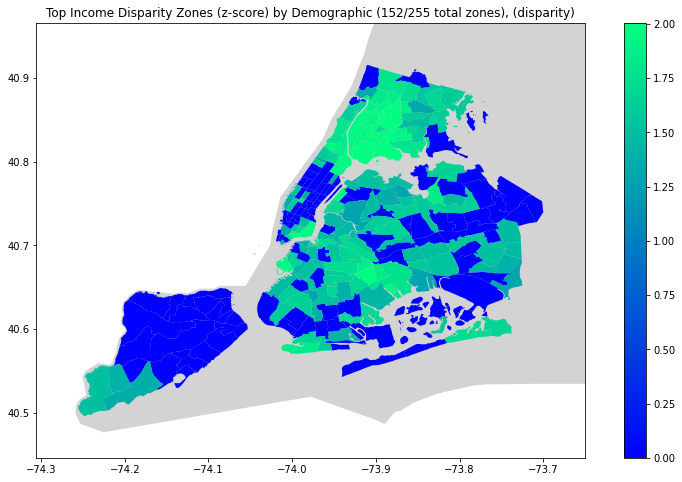

In [0]:
path_read = CREDENTIALS['paths']['demographics_disparity_base']
dict_disparity_demos = {'ethnc_grp':"Ethnicity", 'hshld_incme_grp':"Income"}    # handy data def to loop over

if CREDENTIALS['constants']['EXPERIENCED_MODE'] and CREDENTIALS['constants']['WORKSHOP_ADMIN_MODE']:
    df_disparity = None
    for demo_group in ['gnrt', 'ethnc_grp', 'gndr', 'hshld_incme_grp', 'edctn', 'marital_status_cif']:
        df_disparity_tmp = taxi_zone_demo_disparities(demo_group, quantile_size=10)
        df_grouped = (df_disparity_tmp
            .filter(F.col('overall_quantile')==F.lit(1))
            .groupBy('value').agg(
                F.count('value').alias('count'),
                # F.countDistinct('zone').alias('distinct'),
            )
            .orderBy(F.col('count').desc())
        )
        fn_log(f"Disparities Detected [{demo_group}]: {df_grouped.toPandas().to_dict(orient='records')}")
        if df_disparity is None:    # we're adding a few together...
            df_disparity = df_disparity_tmp
        else:
            df_disparity = df_disparity.union(df_disparity_tmp)  # combine so we can write

    dbutils.fs.rm(path_read, True)
    df_disparity.write.format('delta').save(path_read)
    # end disparity compute
    
df_disparity = spark.read.format('delta').load(path_read)
for demo_group in dict_disparity_demos:
    pdf_disparity = (df_disparity
        .filter(F.col('factor')==F.lit(demo_group))   # filter by the specific demographic
        .groupBy('zone').agg(    # group to set zones we don't care about to zero
            F.min(F.col('overall_quantile')).alias('quantile'),
            F.max(F.when(F.col('overall_quantile')==F.lit(1), F.col('cnt_zscore')).otherwise(F.lit(0))).alias('disparity'),
        )
        .join(df_zones, ['zone'])  # join against the zone shape to plot
        .toPandas()
    )
    pdf_disparity['geometry'] = pdf_disparity['geometry'].apply(lambda x: wkt.loads(x))
    num_total = len(pdf_disparity)
    num_active = len(pdf_disparity[pdf_disparity['quantile']==1])

    # plot the new zone + disparity
    shape_plot_map(pdf_disparity, col_viz='disparity', gdf_background=pdf_shape_states, zscore=False,
                   txt_title=f"Top {dict_disparity_demos[demo_group]} Disparity Zones (z-score) by Demographic ({num_active}/{num_total} total zones)")



# Wrap-up
That's it for this section of exploring data, what did we learn?

* How to explore data in Databricks with 'display' and other basics
* Visualization of the data up front can help to discover some unusual properties
* Adding data for external data can help to understand our own problem better
* Data will often have intrinsic bias ands it's up to you to check and attempt to fix (next part)


If you're hungry for more, proceed to the **02_predict_debiased** notebook next.

As a sneak-preview, we've created the **10_interactive_demos** notebook that allows provides a slightly interactive environment for visualization by different demographics and models that have been created in this workshop.

Alternatively, you can jump into the **90_byo_experiment** notebook to experiment a little on your own data, but this is extra credit and we may not get enough time to jump into the section beforehand.

**Interactive Note**

... and hop back to the slides "Live Quiz! Enrichment Data" to follow along.